### Load data

In [6]:
import pandas as pd
import numpy as np

data = pd.read_csv("/home/hoangbaoan1901/Documents/information-system_UET/sem5/prdan/Homeworks/week-3-btl/datasets/jrfm-2156907.csv")

In [7]:
data['Date'] = pd.to_datetime(data['Date'])

#### Split train, test period

In [8]:
start_day_p2 = pd.Timestamp(2018, 10, 1)
test_day_p2 = pd.Timestamp(2021, 10, 1)
end_day_p2 = pd.Timestamp(2022, 4, 1)

period2 = data[(data["Date"] <= end_day_p2)].reset_index(drop = True)
train_dataset_p2 = period2[period2["Date"] < test_day_p2].reset_index(drop = True)
test_dataset_p2 = period2[period2["Date"] >= test_day_p2].reset_index(drop = True)
train_dataset_p2 = train_dataset_p2.drop(columns = ["Date"])
test_dataset_p2 = test_dataset_p2.drop(columns = ["Date"])

### List Evaluation metrics

In [9]:
# Metrics
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import accuracy_score

def directional_accuracy(y_true, y_pred):
	y_test_da = np.array(y_true)
	y_pred_0 = y_pred[1:] - y_test_da[:-1]
	y_test_0 = y_true[1:] - y_test_da[:-1]
	DA = (y_pred_0<0) == (y_test_0<0)
	return np.mean(DA)*100

### Function to create X and y

In [10]:
# Function to create X and y
def create_train_test(train_dataset, test_dataset):
	X_train = train_dataset[:-1]
	Y_train = train_dataset["BTC_Close"][1:]
	X_test = test_dataset[:-1]
	Y_test = test_dataset["BTC_Close"][1:]
	return X_train, Y_train, X_test, Y_test

X_train_p2, Y_train_p2, X_test_p2, Y_test_p2 = create_train_test(train_dataset_p2, test_dataset_p2)

### Create model

#### Create ParamGrid

In [11]:
from sklearn.model_selection import ParameterGrid
from xgboost import XGBRegressor
params = {
    'min_child_weight': [1],
    'gamma': [0.5, 1, 1.5, 2, 5],
    'subsample': [0.8],
    'colsample_bytree': [0.6, 0.8],
    'max_depth': [6,12, 15],
    'objective': ['reg:squarederror', 'reg:absoluteerror']
}

param_grid = list(ParameterGrid(params))
print(len(param_grid))
print(param_grid[0])

xgb = XGBRegressor(learning_rate=0.02, n_estimators=500, objective='reg:squarederror')

60
{'colsample_bytree': 0.6, 'gamma': 0.5, 'max_depth': 6, 'min_child_weight': 1, 'objective': 'reg:squarederror', 'subsample': 0.8}


In [12]:
import gc
final_model = None
best_score = 1000000000

for param in param_grid:
    xgb.set_params(**param)
    xgb.fit(X_train_p2, Y_train_p2)
    Y_pred = xgb.predict(X_test_p2)
    score = root_mean_squared_error(Y_test_p2, Y_pred)
    if score < best_score:
        best_score = score
        final_model = xgb
        best_param = param
    gc.collect()
    print(param, score)

{'colsample_bytree': 0.6, 'gamma': 0.5, 'max_depth': 6, 'min_child_weight': 1, 'objective': 'reg:squarederror', 'subsample': 0.8} 3866.4230656397494
{'colsample_bytree': 0.6, 'gamma': 0.5, 'max_depth': 6, 'min_child_weight': 1, 'objective': 'reg:absoluteerror', 'subsample': 0.8} 4557.592040209122
{'colsample_bytree': 0.6, 'gamma': 0.5, 'max_depth': 12, 'min_child_weight': 1, 'objective': 'reg:squarederror', 'subsample': 0.8} 3875.9492302172785
{'colsample_bytree': 0.6, 'gamma': 0.5, 'max_depth': 12, 'min_child_weight': 1, 'objective': 'reg:absoluteerror', 'subsample': 0.8} 4200.965706807949
{'colsample_bytree': 0.6, 'gamma': 0.5, 'max_depth': 15, 'min_child_weight': 1, 'objective': 'reg:squarederror', 'subsample': 0.8} 3958.3753090679843
{'colsample_bytree': 0.6, 'gamma': 0.5, 'max_depth': 15, 'min_child_weight': 1, 'objective': 'reg:absoluteerror', 'subsample': 0.8} 4335.831113228909
{'colsample_bytree': 0.6, 'gamma': 1, 'max_depth': 6, 'min_child_weight': 1, 'objective': 'reg:squared

KeyboardInterrupt: 

{'colsample_bytree': 1.0, 'gamma': 5, 'max_depth': 15, 'min_child_weight': 1, 'objective': 'reg:absoluteerror', 'subsample': 0.8} 2490.516495886874
R2 score:  0.8917721581756397
directional_accuracy:  44.19889502762431


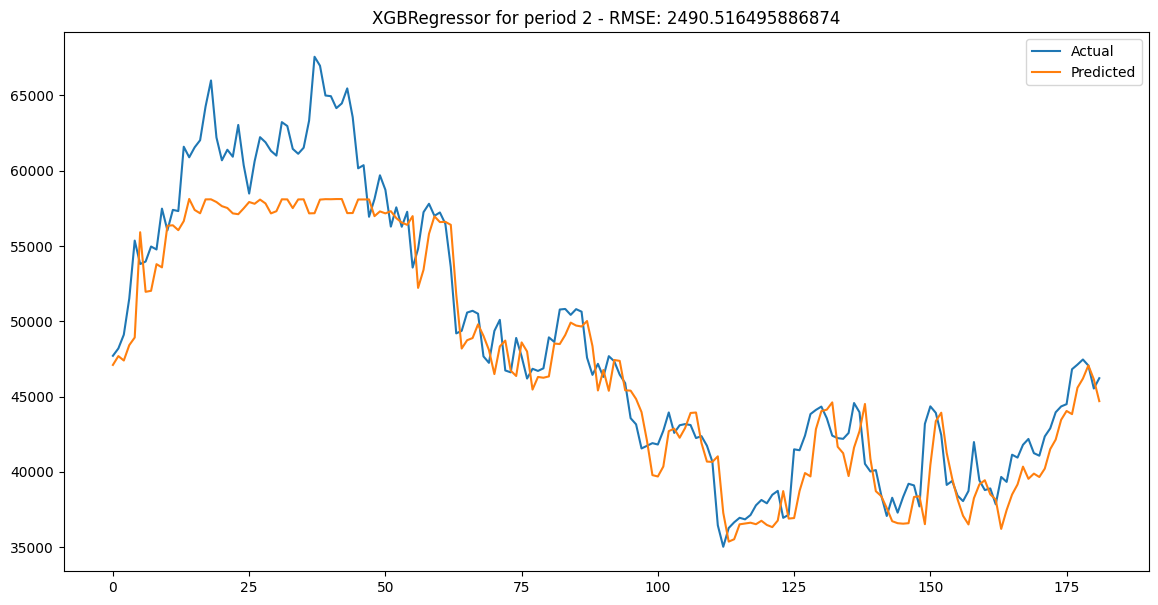

In [ ]:
print(best_param, best_score)
# plot prediction
import matplotlib.pyplot as plt
plt.figure(figsize=(14,7))
plt.title(f"XGBRegressor for period 2 - RMSE: {best_score}")
Y_pred = final_model.predict(X_test_p2)
print("R2 score: ", r2_score(Y_test_p2, Y_pred))
print("directional_accuracy: ", directional_accuracy(Y_test_p2, Y_pred))
plt.plot(Y_test_p2.values, label="Actual")
plt.plot(Y_pred, label="Predicted")
plt.legend()
plt.show()


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

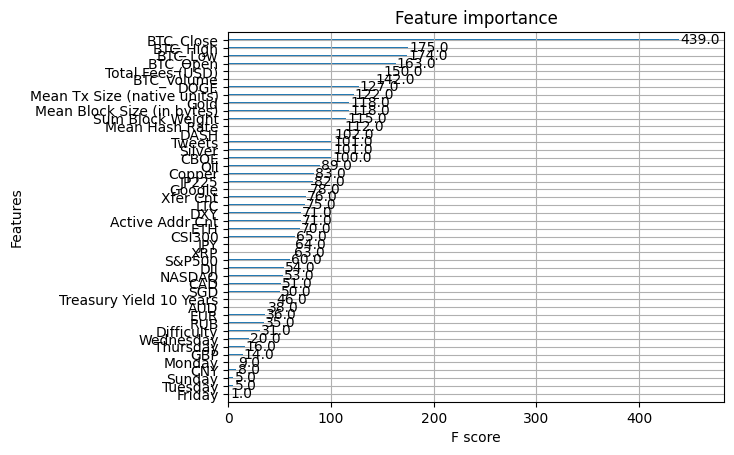

In [ ]:
# plot feature importance
from xgboost import plot_importance
plot_importance(final_model)

In [ ]:
import pickle
import os
file_name = "/home/hoangbaoan1901/Documents/information-system_UET/sem5/prdan/Homeworks/week-3-btl/implementations/models/xgboost_p2.pkl"
if not os.path.exists(file_name):
    os.makedirs(os.path.dirname(file_name), exist_ok=True)
pickle.dump(final_model, open(file_name, "wb"))